In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from astropy.table import Table
from matplotlib import pyplot as plt
import healpy as hp
import fitsio
from glob import glob
from time import time
from scipy.interpolate import splrep, splev

In [3]:
import sys 

sys.path.append(os.path.join(os.getenv("HOME"),'perlmutter_legacysim_runs'))
import useful_functions as ut

sys.path.append(os.path.join(os.getenv("HOME"),'LSS','py'))
from LSS.imaging import sysnet_tools
import LSS.common_tools as common

#sys.path.append("/global/homes/a/arosado/sysnetdev")
from sysnet.sources.train import forward
from sysnet.sources.models import DNNPoisson
from sysnet.sources.io import load_checkpoint, ImagingData, MyDataSet, DataLoader

In [4]:
def extrapolate_weights(datapix, wt_map, k=1, der=0):
    # get missing weight, note: pixels must be sorted
    pix = datapix
    hpmap = wt_map
    is_unseen = hpmap[pix] == hp.UNSEEN
    t0 = time()
    # #https://datasciencestunt.com/extrapolation-vs-interpolation/#Spline_Extrapolation_with_Python_Code
    x = pix[~is_unseen] 
    y = hpmap[x]#[pix][~is_unseen]
    #print(x,y)
    # Spline extrapolation function
    spl = splrep(x, y, k=k)
    x_new = pix[is_unseen]
    y_new = splev(x_new, spl, der=der)
    print(f"Spline extrapolation finished at {time() - t0:.3f} s")
    
    return x_new, y_new

In [5]:
regions = ['N','S']
zl = ['0.8_1.1','1.1_1.6']
tp = 'ELG_LOPnotqso' # tracer type
sv = 'v0.6'          # survey version

survey_dir = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{sv}/"
outdir  = os.path.join(os.getenv('HOME'),'sysgen2')
sysdir  = os.path.join(survey_dir,'sysnet')
prepdir = sysdir

In [6]:
#!ls -l /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock*

In [7]:
#!ls -l /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/

# Forward model 
To do:
- instead of using features from prepared data used to train, try making templates based on mock hpix. I think this way all mock hpix will have assigned weights, and I would not need to extrapolate them later on.

In [8]:
def do_forward(checkpoints,templates,outfn,axes=[1, 2, 3, 4, 5, 6, 7, 8]):
    nnw_list = [] 
    #hpix_list = []
    num_features = len(axes) # nside=1024, 27 for nside=256
    nnstruct = (4, 20)
    
    ti = time()
    model = DNNPoisson(*nnstruct, input_dim=num_features)
    for i, chck in enumerate(checkpoints):        

        t0 = time()
        checkpoint = load_checkpoint(chck, model)
        img_data = ImagingData(templates, checkpoint['stats'], axes=axes)
        dataloader = DataLoader(MyDataSet(img_data.x, img_data.y, img_data.p, img_data.w),
                                 batch_size=2000000,
                                 shuffle=False) # num_workers=4
                                
        #print(f'finish data in {time()-t0:.2f} s, {i}')
        result = forward(model, dataloader, {'device':'cpu'})        
        nnw = result[1].numpy().flatten()
        hpix = result[0].numpy()
        nnw_list.append(nnw)
        #hpix_list.append(hpix)
        #print(f'finished forward pass in {time()-t0:.2f} s, {i}')
        
    print(f'finished forward pass for {len(checkpoints)} checkpoints in {time()-ti:.2f} s')   
    nnw_mean = np.mean(nnw_list,axis=0)    
    #print(nnw_mean)
    dt = Table([hpix, nnw_mean], names=['hpix', 'weight'])
    dt.write(outfn, format='fits')
    print(f'save in {outfn}')

In [9]:
mockid = 10
for zr in zl:
    print(zr)
    for reg in regions:
        print(reg)
        outfn = os.path.join(outdir,f"nn-weights_{tp}{zr}_{reg}.fits")
        nndir   = os.path.join(sysdir,f"{tp}{zr}_{reg}/")
        chcks2   = [sorted(glob(nndir+'model_*/best.pth.tar'))[mockid]]
        chcks   = glob(nndir+'model_*/best.pth.tar')
        templates = fitsio.read(prepdir+f"/prep_{tp}{zr}_{reg}.fits")
        axes = [i for i in range(templates['features'].shape[1])]
        # we want the imaging weights due to EBV_DIFF only, which correspond to axes=8 in 'features'
        #for ax in range(templates['features'].shape[1]):
        #    if ax!=8:
        #        templates['features'][:,ax] = np.full(templates['features'][:,ax].shape, np.median(templates['features'][:,ax]))

        #print(len(chcks), templates.size, chcks[:2])
        t = do_forward(chcks, templates, outfn, axes=axes)
        t2 = do_forward(chcks2, templates, outfn, axes=axes)
        
print(chcks)

0.8_1.1
N
finished forward pass for 25 checkpoints in 16.26 s
finished forward pass for 1 checkpoints in 0.65 s
S
finished forward pass for 25 checkpoints in 61.58 s
finished forward pass for 1 checkpoints in 2.84 s
1.1_1.6
N
finished forward pass for 25 checkpoints in 19.39 s
finished forward pass for 1 checkpoints in 0.61 s
S
finished forward pass for 25 checkpoints in 60.80 s
finished forward pass for 1 checkpoints in 2.28 s
['/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_1_3865606280/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_0_2664486226/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_1_2285845164/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_1_1280952859/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron

In [12]:
t['weight'][500],t2['weight'][500]

(21.548916, 21.246107)

In [7]:
for zr in zl:
    print(zr)
    for reg in regions:
        print(reg)
        outfn = os.path.join(outdir,f"nn-weights_{tp}{zr}_{reg}.fits")
        nndir   = os.path.join(sysdir,f"{tp}{zr}_{reg}/")
        chcks   = glob(nndir+'model_*/best.pth.tar')
        templates = fitsio.read(prepdir+f"/prep_{tp}{zr}_{reg}.fits")
        axes = [i for i in range(templates['features'].shape[1])]
        # we want the imaging weights due to EBV_DIFF only, which correspond to axes=8 in 'features'
        #for ax in range(templates['features'].shape[1]):
        #    if ax!=8:
        #        templates['features'][:,ax] = np.full(templates['features'][:,ax].shape, np.median(templates['features'][:,ax]))

        #print(len(chcks), templates.size, chcks[:2])
        #do_forward(chcks, templates, outfn, axes=axes)
        
print(chcks)

0.8_1.1
N
S
1.1_1.6
N
S
['/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_1_3865606280/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_0_2664486226/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_1_2285845164/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_1_1280952859/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_2_2285845164/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_2_2664486226/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/ELG_LOPnotqso1.1_1.6_S/model_2_3865606280/best.pth.tar', '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/sysnet/

In [13]:
nside = 256
for zr in zl:
    print(zr)
    count_i = np.zeros(12*nside*nside)
    wind_i = np.zeros(12*nside*nside)
    for reg in regions:
        print(reg)
        outfn = os.path.join(outdir,f"nn-weights_{tp}{zr}_{reg}.fits")
        nn = fitsio.read(outfn)
        wind_i[nn['hpix']] += nn['weight'] 
        count_i[nn['hpix']] += 1.0
        
    output_path = os.path.join(outdir,f"nn-weights_{tp}{zr}_NS.fits")
    #print(output_path)
    is_good = count_i > 0.0
    wind_i[is_good] = wind_i[is_good] / count_i[is_good]
    wind_i[~is_good] = hp.UNSEEN
    hp.write_map(output_path, wind_i, dtype=np.float64, fits_IDL=False) 
    print(f"saved {output_path}")

0.8_1.1
N
S
saved /global/homes/a/arosado/sysgen2/nn-weights_ELG_LOPnotqso0.8_1.1_NS.fits
1.1_1.6
N
S
saved /global/homes/a/arosado/sysgen2/nn-weights_ELG_LOPnotqso1.1_1.6_NS.fits


# Contaminate Mocks
To do:
- For some reason clustering data is not clean after applying 'WEIGHT'

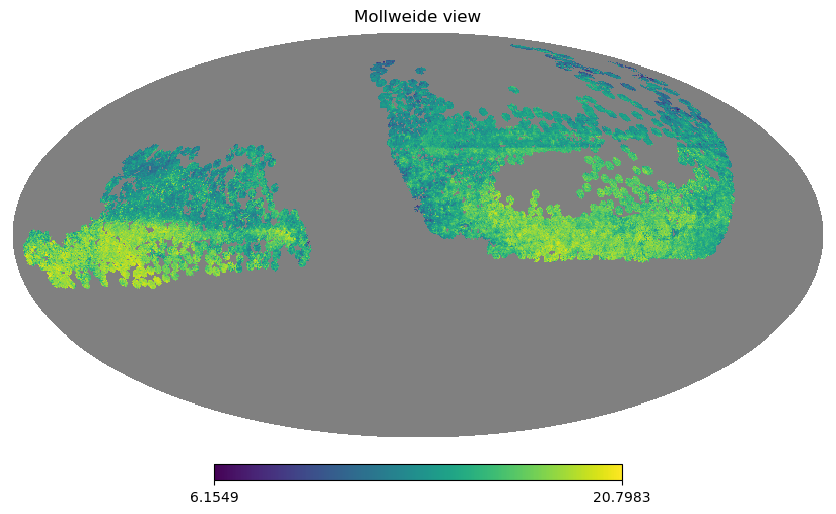

In [8]:
hfn = f"/global/homes/a/arosado/sysgen2/nn-weights_{tp}{zl[0]}_NS.fits"
h = hp.read_map(hfn)
hp.mollview(h,rot=260)

In [24]:
nside = 256
nest = True
nran = 4
mockid = 19
regions = ['NGC','SGC']
reg = regions[0]
print(reg)
zr = zl[1]
zmin,zmax = zr.split('_')
zmin,zmax = float(zmin),float(zmax)
print(zmin,zmax)
mockdir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/'

NGC
1.1 1.6


In [25]:
%%time
# load randoms
#rfn_l = [os.path.join(survey_dir,f"{tp}_{i}_full.ran.fits") for i in range(0,nran)]
if tp=='ELG_LOPnotqso':
    tp_="ELG_LOP"
    rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
else:
    rfn_l = [os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
#print(rfn_l)
ranl = []
for rfn in rfn_l:
    ran = fitsio.read(rfn, columns=['RA', 'DEC'])#,'PHOTSYS']) 
    ranl.append(ran)
rands = np.concatenate(ranl)

CPU times: user 1.56 s, sys: 1.08 s, total: 2.63 s
Wall time: 3.23 s


In [26]:
#fn = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/forFA{mockid}.fits"#_matched_input_full_lrg_imask.fits"
if tp=='ELG_LOPnotqso':
    tp_="ELG_LOP"
    fn = os.path.join(mockdir,f"mock{mockid}",f"{tp_}_complete_gtlimaging_{reg}_clustering.dat.fits")
else:
    fn = os.path.join(mockdir,f"mock{mockid}",f"{tp}_complete_gtlimaging_{reg}_clustering.dat.fits")          
mock = fitsio.read(fn)
zgood = (mock['Z'] > zmin) & (mock['Z'] < zmax)
mock = mock[zgood]
#iselg = mock['DESI_TARGET'] == 34
#mock = mock[iselg]
#zgood = (mock['TRUEZ'] > zmin) & (mock['TRUEZ'] < zmax)
#mock.dtype.names

In [27]:
# maps used when fitting for weights
bands = ["G","R","Z"]
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS'] + \
               [f'PSFSIZE_{b}' for b in bands] + \
               [f'GALDEPTH_{b}' for b in bands] + \
               ['EBV_DIFF_GR','EBV_DIFF_RZ','HI']
print(len(fit_maps),fit_maps)

# load Ronpu EBV maps
dirmap = '/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/v0/kp3_maps/'
eclrs = ['gr','rz']
debv = Table()
for ec in eclrs:
    ebvn = fitsio.read(dirmap+'v0_desi_ebv_'+ec+'_'+str(nside)+'.fits')
    debv_a = ebvn['EBV_DESI_'+ec.upper()]-ebvn['EBV_SFD']
    debv_a = hp.reorder(debv_a,r2n=True)
    debv['EBV_DIFF_'+ec.upper()] = debv_a


#pwf = os.path.join(survey_dir,'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_'+rg+'.fits')
pwf = os.path.join("/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.4/",'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'.fits')
sys_tab = Table.read(pwf)
cols = list(sys_tab.dtype.names)
for col in cols:
    if 'DEPTH' in col:
        bnd = col.split('_')[-1]
        sys_tab[col] *= 10**(-0.4*common.ext_coeff[bnd]*sys_tab['EBV'])
for ec in ['GR','RZ']:
    if 'EBV_DIFF_'+ec in fit_maps: 
        sys_tab['EBV_DIFF_'+ec] = debv['EBV_DIFF_'+ec]
#systabs.append(sys_tab)

10 ['STARDENS', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'EBV_DIFF_GR', 'EBV_DIFF_RZ', 'HI']


Spline extrapolation finished at 0.008 s
[-1.6375e+30 -1.6375e+30 -1.6375e+30 ... -1.6375e+30 -1.6375e+30
 -1.6375e+30] 4180
[16.28437154 16.47074779 13.76442275 ... 32.94918207 32.956938
 32.96469393] 4180
4180


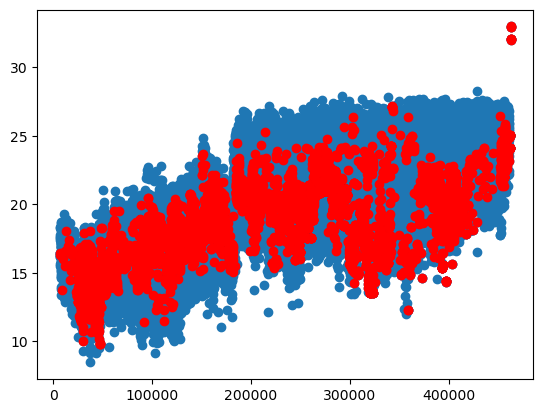

In [28]:
pixs = sysnet_tools.radec2hpix(nside,mock['RA'],mock['DEC'])
pix = np.unique(pixs)
sn = hp.read_map(f"/global/homes/a/arosado/sysgen2/nn-weights_{tp}{zr}_NS.fits")
pixi,wts = extrapolate_weights(np.sort(pix), sn, k=1, der=0)
print(sn[pixi],sn[pixi].size)
sn[pixi] = wts
print(sn[pixi],sn[pixi].size)
plt.scatter(pix,sn[pix])
plt.scatter(pixi,sn[pixi],c='r')
is_seen = sn[pixs] == hp.UNSEEN
print(pixi.size)

In [34]:
wts = sn[pixs] / np.median(sn[pixs])

hpmaps = sysnet_tools.create_sysmaps(sys_tab, nest=nest, columns=fit_maps)
mock_hpmap, rands_hpmap = sysnet_tools.hpixelize(nside, mock, rands, nest=False, return_mask=False, nest2ring=False) 
cont_hpmap, _ = sysnet_tools.hpixelize(nside, mock, rands, weights=wts, nest=False, return_mask=False, nest2ring=False) 
#cont_hpmap, _ = sysnet_tools.hpixelize(nside, mock[is_seen], rands, weights=sn[pixs][is_seen], nest=False, return_mask=False, nest2ring=False) 
mask = rands_hpmap > 0

In [35]:
%%time
# load clustering catalogs for comparison
# load data
dfn = os.path.join(survey_dir,'blinded',f"{tp}_{reg}_clustering.dat.fits")
print(dfn)
dat = fitsio.read(dfn)
zgood = (dat['Z'] > zmin) & (dat['Z'] < zmax)
dat = dat[zgood]

# load randoms
rfn_l = [os.path.join(survey_dir,'blinded',f"{tp}_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
#print(rfn_l)
ranl = []
for rfn in rfn_l:
    ran = fitsio.read(rfn, columns=['RA', 'DEC', 'FRAC_TLOBS_TILES','WEIGHT']) 
    ranl.append(ran)
drands = np.concatenate(ranl)

/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/ELG_LOPnotqso_NGC_clustering.dat.fits
CPU times: user 2.96 s, sys: 2.3 s, total: 5.26 s
Wall time: 5.41 s


In [36]:
dpixs = sysnet_tools.radec2hpix(nside,dat['RA'],dat['DEC'])
dwts = dat['WEIGHT']
drands_hpmap = sysnet_tools.hpixsum(nside,drands['RA'],drands['DEC'],weights=drands['WEIGHT'])
data_hpmap, _ = sysnet_tools.hpixelize(nside, dat, drands, nest=False, return_mask=False, nest2ring=False)
clean_hpmap, _ = sysnet_tools.hpixelize(nside, dat, drands, weights=dwts, nest=False, return_mask=False, nest2ring=False)
#mask &= drands_hpmap > 0 

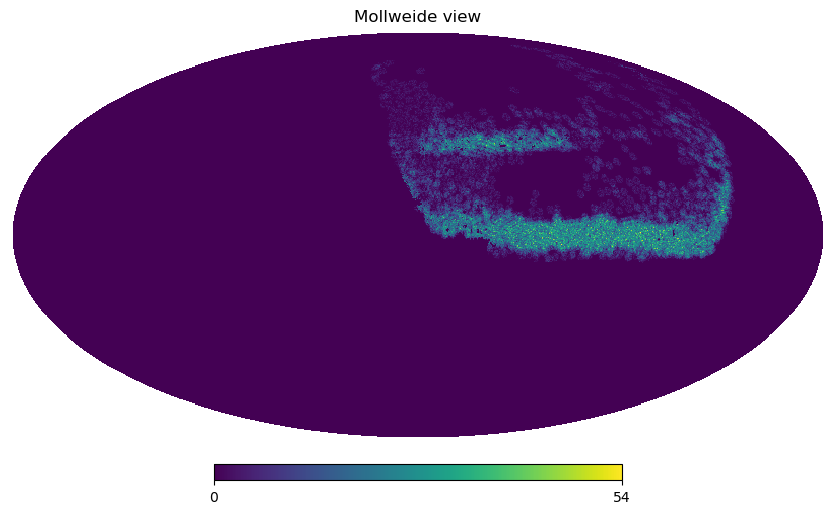

In [37]:
hp.mollview(data_hpmap,rot=260)

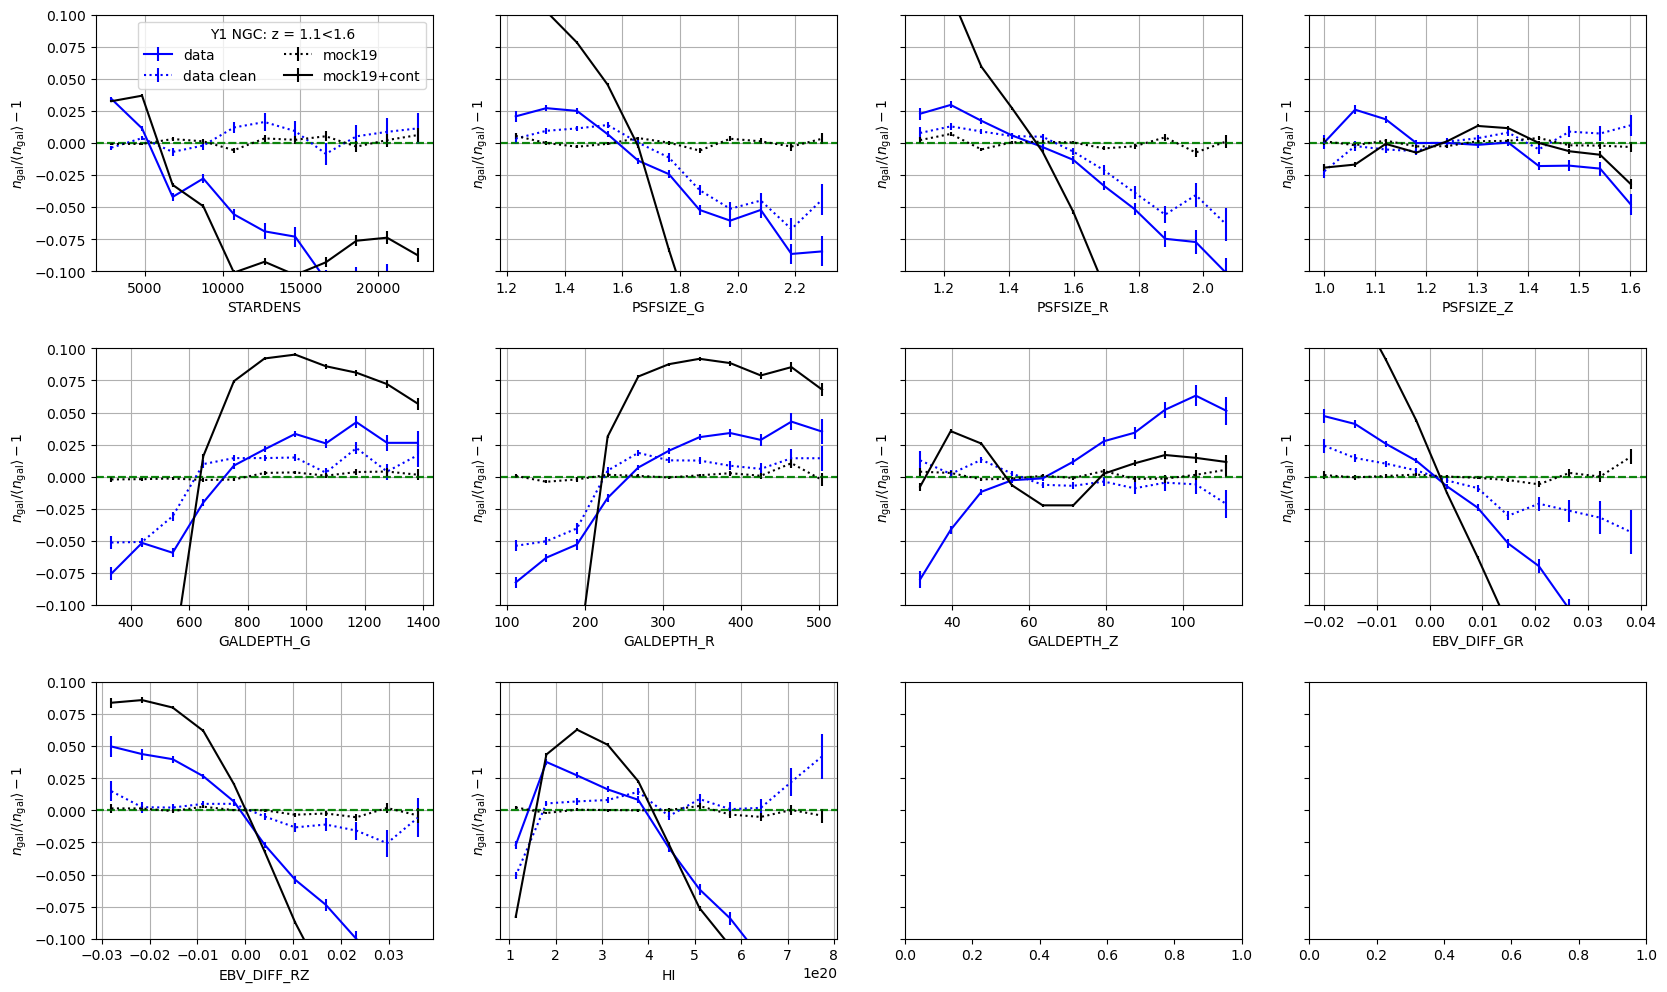

In [38]:
binning = 'linear'
ylim = (-0.3, +0.1)
#plot
fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
fig.subplots_adjust(hspace=0.3,wspace=0.2)
lax = lax.flatten()
add_maps = []
for iax, prop in enumerate(fit_maps+add_maps):
    kw = (hpmaps,prop,mask)
    kws = dict(binning=binning)
    # data
    ut.plot_density_variations(lax[iax], data_hpmap, drands_hpmap, hpmaps, prop, mask, label=f'data', color='b', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], clean_hpmap, drands_hpmap, hpmaps, prop, mask, label=f'data clean', color='b', linestyle=':', **kws)
    
    #mock
    ut.plot_density_variations(lax[iax], mock_hpmap, rands_hpmap, label=f'mock{mockid}', color='k', linestyle=':', *kw, **kws)
    ut.plot_density_variations(lax[iax], cont_hpmap, rands_hpmap, label=f'mock{mockid}+cont', color='k', linestyle='-', *kw, **kws)
    #ut.plot_density_variations(lax[iax], cont2_hpmap, rands_hpmap, label=f'mock{mockid}+cont2', color='r', linestyle=':', *kw, **kws)
    lax[iax].axhline(y=1.0, color='g')
lax[0].legend(title=f'Y1 {reg}: z = {zmin}<{zmax}', ncol=2)
plt.show()

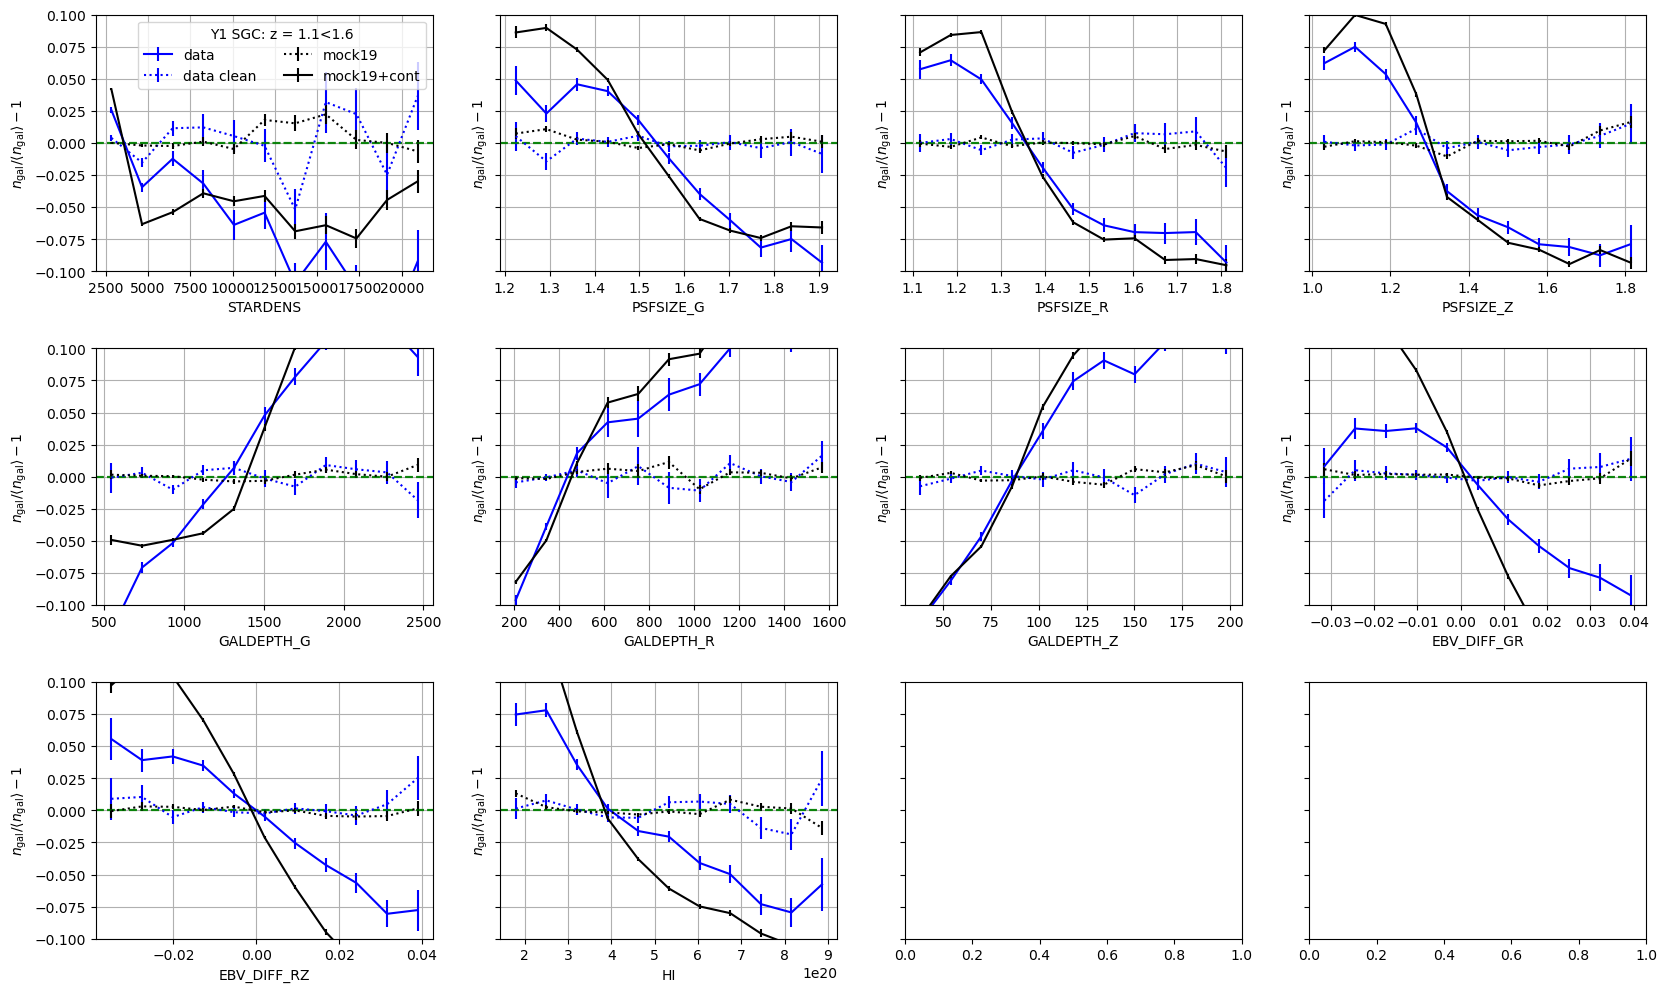

In [18]:
binning = 'linear'
ylim = (-0.3, +0.1)
#plot
fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
fig.subplots_adjust(hspace=0.3,wspace=0.2)
lax = lax.flatten()
add_maps = []
for iax, prop in enumerate(fit_maps+add_maps):
    kw = (hpmaps,prop,mask)
    kws = dict(binning=binning)
    # data
    ut.plot_density_variations(lax[iax], data_hpmap, drands_hpmap, hpmaps, prop, mask, label=f'data', color='b', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], clean_hpmap, drands_hpmap, hpmaps, prop, mask, label=f'data clean', color='b', linestyle=':', **kws)
    
    #mock
    ut.plot_density_variations(lax[iax], mock_hpmap, rands_hpmap, label=f'mock{mockid}', color='k', linestyle=':', *kw, **kws)
    ut.plot_density_variations(lax[iax], cont_hpmap, rands_hpmap, label=f'mock{mockid}+cont', color='k', linestyle='-', *kw, **kws)
    #ut.plot_density_variations(lax[iax], cont2_hpmap, rands_hpmap, label=f'mock{mockid}+cont2', color='r', linestyle=':', *kw, **kws)
    lax[iax].axhline(y=1.0, color='g')
lax[0].legend(title=f'Y1 {reg}: z = {zmin}<{zmax}', ncol=2)
plt.show()

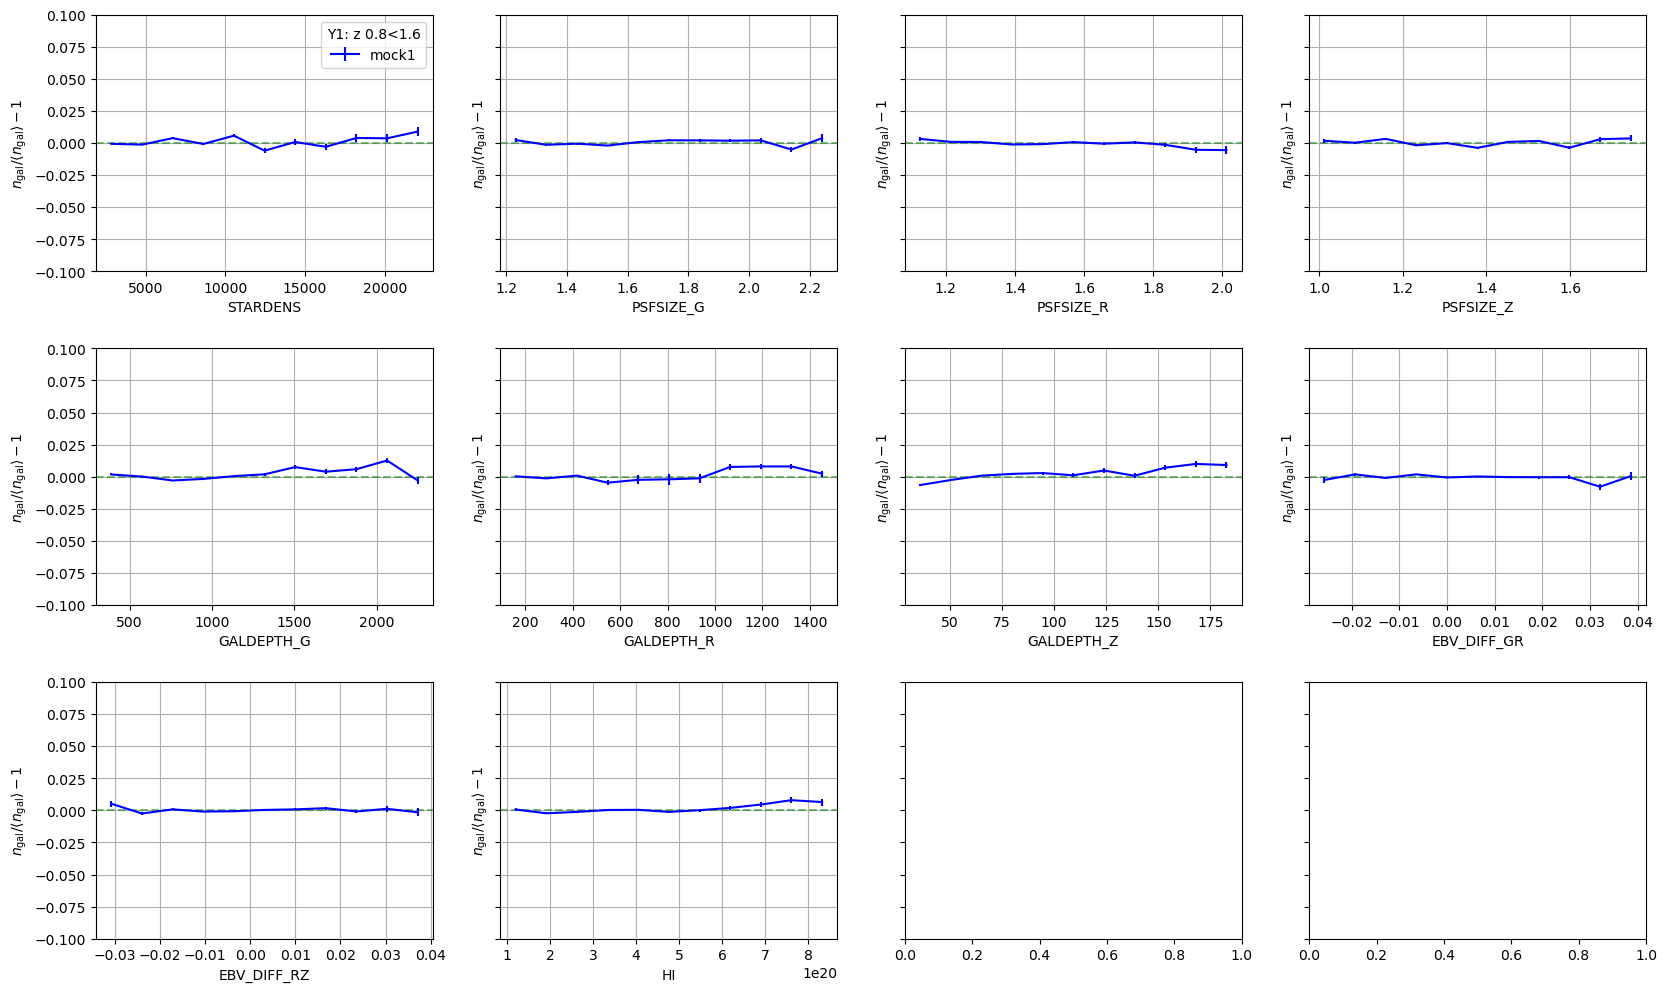

In [10]:
binning = 'linear'
ylim = (-0.3, +0.1)
#plot
fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
fig.subplots_adjust(hspace=0.3,wspace=0.2)
lax = lax.flatten()
add_maps = []
for iax, prop in enumerate(fit_maps+add_maps):
    kw = (hpmaps,prop,mask)
    kws = dict(binning=binning)
    ut.plot_density_variations(lax[iax], data_hpmap, rands_hpmap, label=f'mock{mockid}', color='b', linestyle='-', *kw, **kws)
    lax[iax].axhline(y=1.0, color='g')
lax[0].legend(title=f'Y1: z {zmin}<{zmax}', ncol=2)
plt.show()

# Contaminate Mocks (full)

In [8]:
nside = 256
nest = True
nran = 4
mockid = 19
regions = ['NGC','SGC']
#reg = regions[0]
#print(reg)
zr = zl[1]
zmin,zmax = zr.split('_')
zmin,zmax = float(zmin),float(zmax)
print(zmin,zmax)
mockdir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/'

1.1 1.6


In [9]:
%%time
# load clustering catalogs for comparison
# load data
datl = []
for reg in regions:
    dfn = os.path.join(survey_dir,'blinded',f"{tp}_{reg}_clustering.dat.fits")
    print(dfn)
    dat = fitsio.read(dfn)
    zgood = (dat['Z'] > zmin) & (dat['Z'] < zmax)
    dat = dat[zgood]
    datl.append(dat)
dat = np.concatenate(datl)

# load randoms
ranl = []
for reg in regions:
    rfn_l = [os.path.join(survey_dir,'blinded',f"{tp}_{reg}_{i}_clustering.ran.fits") for i in range(0,nran)]
    #print(rfn_l)
    for rfn in rfn_l:
        ran = fitsio.read(rfn, columns=['RA', 'DEC', 'FRAC_TLOBS_TILES','WEIGHT']) 
        ranl.append(ran)
drands = np.concatenate(ranl)

/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/ELG_LOPnotqso_NGC_clustering.dat.fits
/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/ELG_LOPnotqso_SGC_clustering.dat.fits
CPU times: user 5.75 s, sys: 8.36 s, total: 14.1 s
Wall time: 16.8 s


In [10]:
dat['Z'].min(),dat['Z'].max(), dat['Z'].size

(1.1000000633304539, 1.5999984479162008, 1445667)

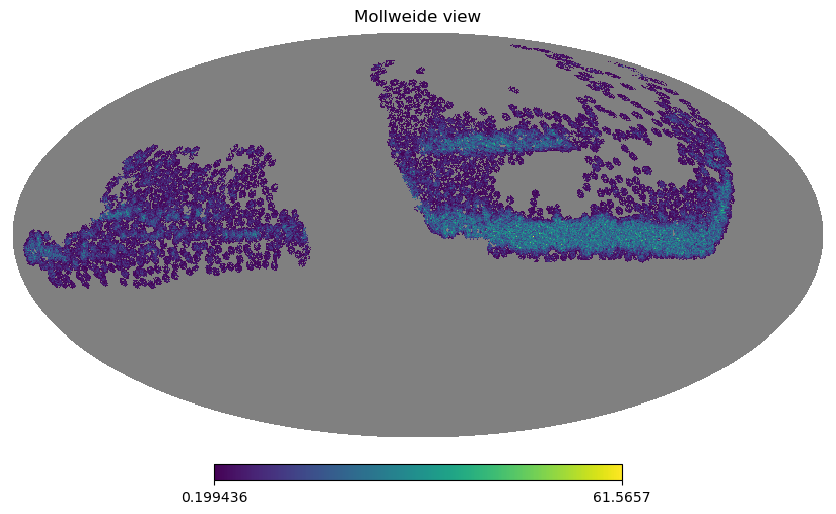

In [11]:
m = sysnet_tools.hpixsum(nside,dat['RA'],dat['DEC'],weights=dat['WEIGHT'])
is_seen = m > 0 
m[~is_seen] = hp.UNSEEN
hp.mollview(m,rot=260)

In [12]:
is_north = dat['DEC'] >= 32.375
datn = dat[is_north]
dats = dat[~is_north]

is_north_rands = drands['DEC'] >= 32.375
drands_n = drands[is_north_rands]
drands_s = drands[~is_north_rands]

datn_m  = sysnet_tools.hpixsum(nside, datn['RA'],datn['DEC'])
datn_mc = sysnet_tools.hpixsum(nside, datn['RA'],datn['DEC'],weights=datn['WEIGHT'])
drn_m = sysnet_tools.hpixsum(nside,drands_n['RA'],drands_n['DEC'],weights=drands_n['WEIGHT'])
mask_n = drn_m > 0 

dats_m  = sysnet_tools.hpixsum(nside, dats['RA'],dats['DEC'])
dats_mc = sysnet_tools.hpixsum(nside, dats['RA'],dats['DEC'],weights=dats['WEIGHT'])
drs_m = sysnet_tools.hpixsum(nside,drands_s['RA'],drands_s['DEC'],weights=drands_s['WEIGHT'])
mask_s = drs_m > 0 

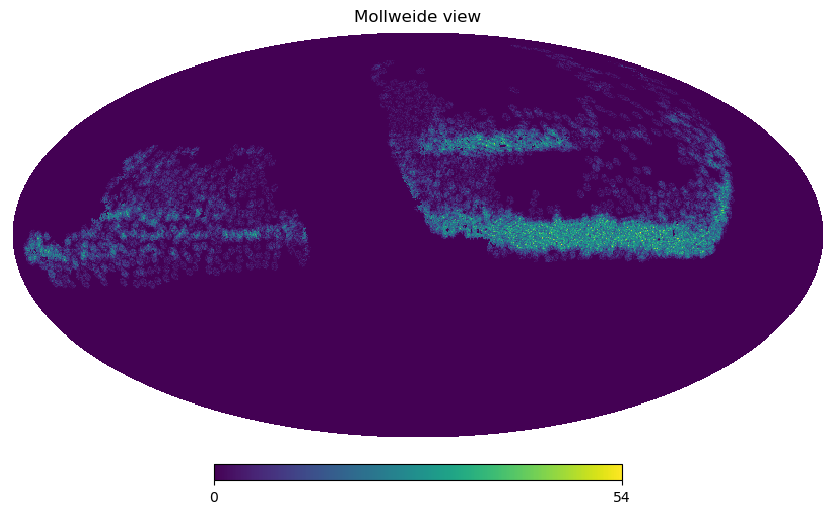

In [13]:
d = dat
m = sysnet_tools.hpixsum(nside,d['RA'],d['DEC'])#,weights=d['WEIGHT'])
is_seen = m > 0 
#m[~is_seen] = hp.UNSEEN
hp.mollview(m,rot=260)

In [14]:
# maps used when fitting for weights
bands = ["G","R","Z"]
if tp[:3] == 'ELG':
    fit_maps = ['STARDENS'] + \
               [f'PSFSIZE_{b}' for b in bands] + \
               [f'GALDEPTH_{b}' for b in bands] + \
               ['EBV_DIFF_GR','EBV_DIFF_RZ','HI']
print(len(fit_maps),fit_maps)

# load Ronpu EBV maps
dirmap = '/global/cfs/cdirs/desicollab/users/rongpu/data/ebv/v0/kp3_maps/'
eclrs = ['gr','rz']
debv = Table()
for ec in eclrs:
    ebvn = fitsio.read(dirmap+'v0_desi_ebv_'+ec+'_'+str(nside)+'.fits')
    debv_a = ebvn['EBV_DESI_'+ec.upper()]-ebvn['EBV_SFD']
    debv_a = hp.reorder(debv_a,r2n=True)
    debv['EBV_DIFF_'+ec.upper()] = debv_a

sys_tabs = []
for reg in ['N','S','']:
    if reg == '':
        pwf = os.path.join("/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.4/",'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'.fits')
    else:
        pwf = os.path.join(survey_dir,'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_'+reg+'.fits')
    sys_tab = Table.read(pwf)
    cols = list(sys_tab.dtype.names)
    for col in cols:
        if 'DEPTH' in col:
            bnd = col.split('_')[-1]
            sys_tab[col] *= 10**(-0.4*common.ext_coeff[bnd]*sys_tab['EBV'])
    for ec in ['GR','RZ']:
        if 'EBV_DIFF_'+ec in fit_maps: 
            sys_tab['EBV_DIFF_'+ec] = debv['EBV_DIFF_'+ec]
    sys_tabs.append(sys_tab)

10 ['STARDENS', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'EBV_DIFF_GR', 'EBV_DIFF_RZ', 'HI']


In [15]:
%%time 
# load full data catalog
zcolumn = 'Z_not4clus'
keep = ["RA","DEC","TARGETID","PHOTSYS","FRACZ_TILELOCID","WEIGHT_ZFAIL",
        "ZWARN","o2c","FRAC_TLOBS_TILES",zcolumn]#"WEIGHT_SYS"]
dfn = os.path.join(survey_dir,f"{tp}_full.dat.fits")
print(dfn)
dat_full = fitsio.read(dfn,columns=keep)

# load full randoms
rfn_l = [os.path.join(survey_dir,f"{tp}_{i}_full.ran.fits") for i in range(0,nran)]
#print(rfn_l)
ranl = []
for rfn in rfn_l:
    ran = fitsio.read(rfn, columns=['RA', 'DEC','PHOTSYS']) 
    ranl.append(ran)
rands = np.concatenate(ranl)

#selection
sel_obs = dat_full['ZWARN'] != 999999
sel_obs &= dat_full['o2c'] > 0.9
sel_obs &= (zmin < dat_full[zcolumn]) & (dat_full[zcolumn] < zmax)

dat_full_list   = []
dat_fullc_list  = []
rands_full_list = []
mask_full_list = []
for reg in ['N','S']:
    sn_fn = os.path.join(survey_dir,"sysnet",f"{tp}{zmin}_{zmax}_{reg}","nn-weights.fits")
    sn_weights = fitsio.read(sn_fn)
    pred_counts = np.mean(sn_weights['weight'],axis=1)
    pix_weight = np.mean(pred_counts)/pred_counts
    pix_weight = np.clip(pix_weight,0.5,2.)
    sn_pix = sn_weights['hpix']
    snmap = np.ones(12*256*256)
    for pix,wt in zip(sn_pix,pix_weight):
        snmap[pix] = wt
    seld = dat_full['PHOTSYS'] ==  reg
    selr = rands['PHOTSYS'] == reg
    d = dat_full[sel_obs&seld]
    r = rands[selr]
    dpix = sysnet_tools.radec2hpix(nside,d['RA'],d['DEC'])
    
    dwts = 1./d['FRAC_TLOBS_TILES'] * 1./d['FRACZ_TILELOCID'] * d['WEIGHT_ZFAIL']
    dat_full_list.append(sysnet_tools.hpixsum(nside, d['RA'],d['DEC'],weights=dwts))
    rmap = sysnet_tools.hpixsum(nside, r['RA'],r['DEC'])
    rands_full_list.append(rmap)
    mask_full_list.append(rmap>0)
    dat_fullc_list.append(sysnet_tools.hpixsum(nside, d['RA'],d['DEC'],weights=dwts*snmap[dpix]))


/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/ELG_LOPnotqso_full.dat.fits
CPU times: user 20.7 s, sys: 31.3 s, total: 52 s
Wall time: 53.5 s


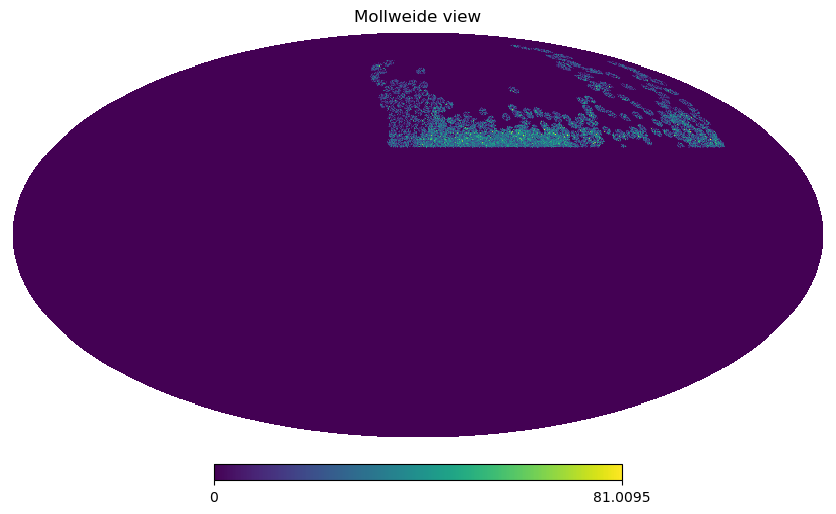

In [22]:
hp.mollview(dat_full_list[0],rot=260)

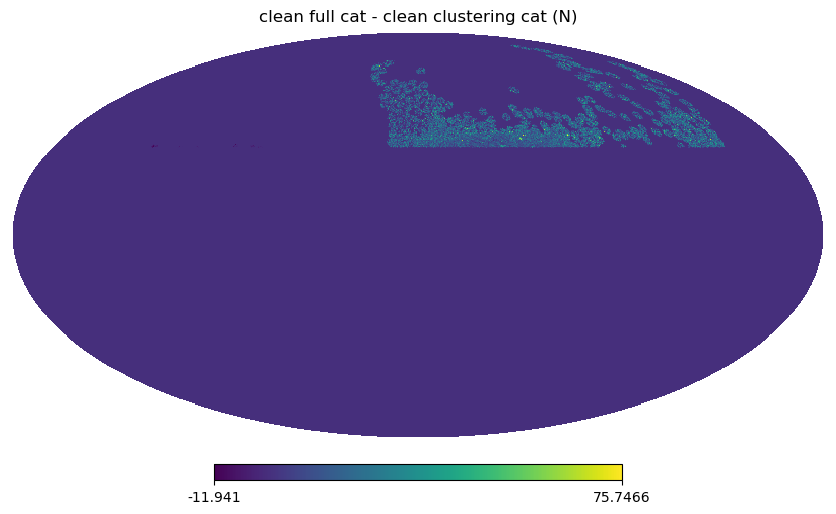

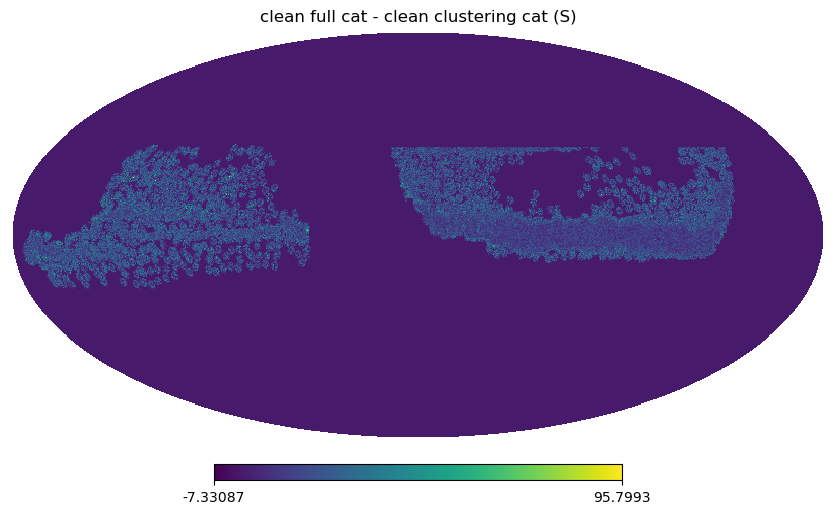

In [30]:
for i,regm in enumerate([datn_mc,dats_mc]):
    regs = ['N','S']
    hp.mollview(dat_fullc_list[i]-regm,rot=260,title=f"clean full cat - clean clustering cat ({regs[i]})")
    plt.savefig(f"diffmap_{regs[i]}.png")
    plt.show()

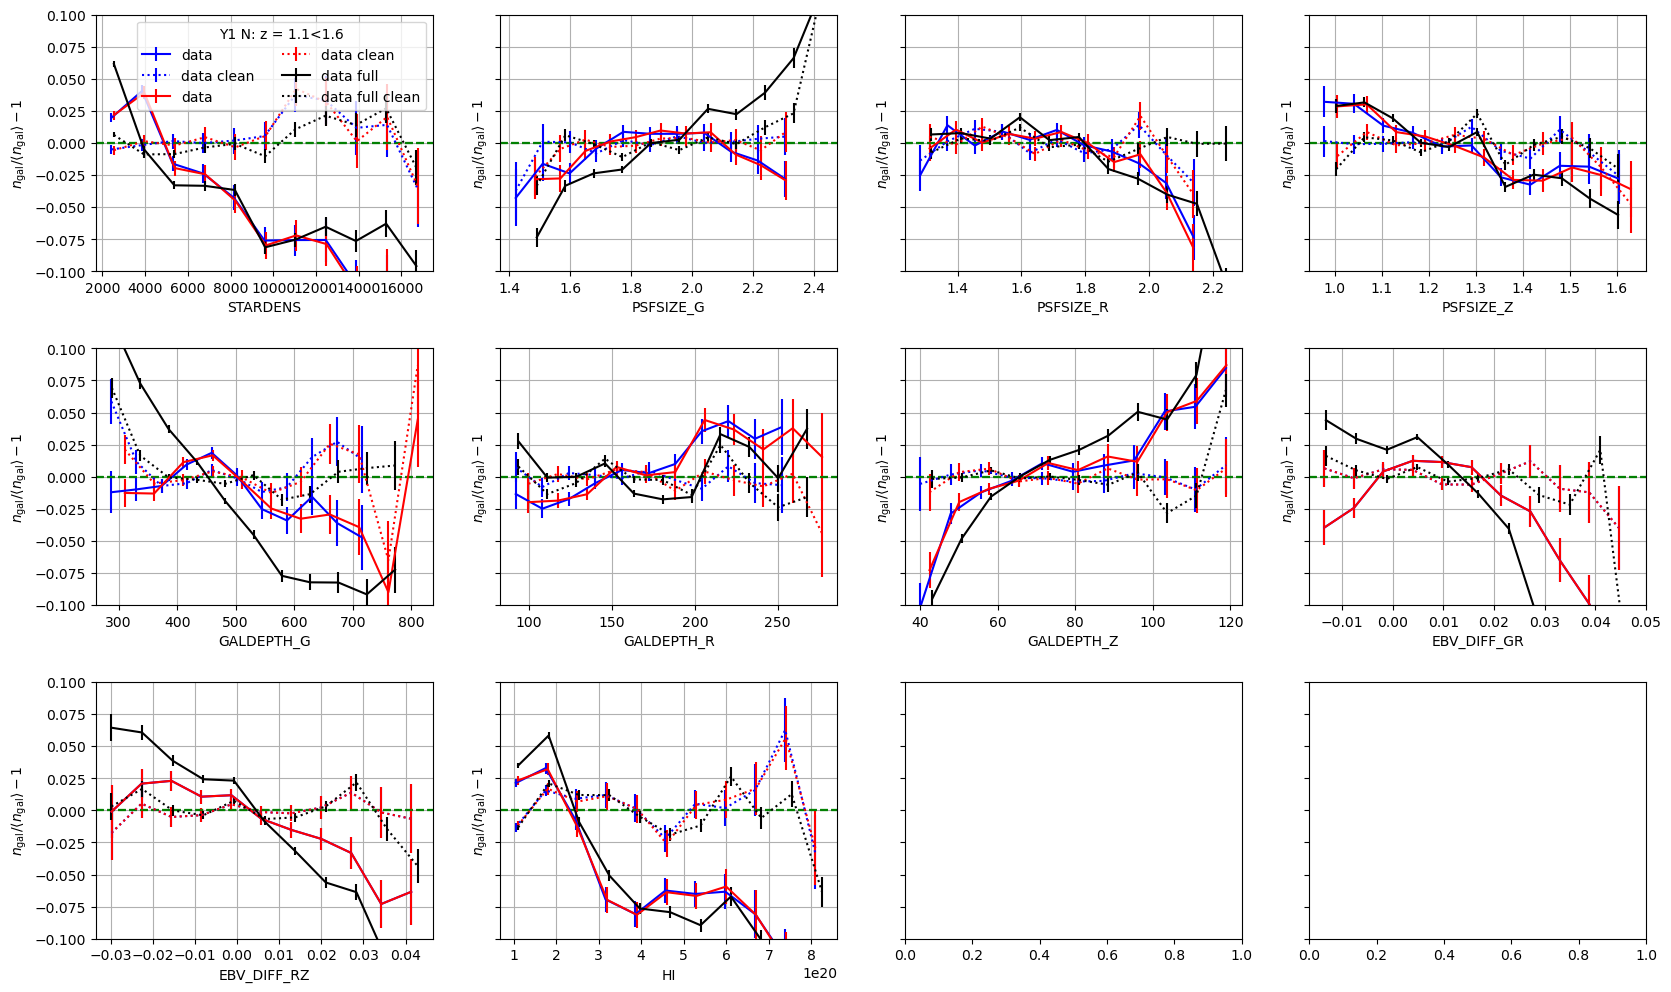

In [91]:
binning = 'linear'
ylim = (-0.3, +0.1)
#plot
fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
fig.subplots_adjust(hspace=0.3,wspace=0.2)
lax = lax.flatten()
add_maps = []
for iax, prop in enumerate(fit_maps+add_maps):
    kws = dict(binning=binning)
    # data
    hpmaps = sysnet_tools.create_sysmaps(sys_tabs[0], nest=nest, columns=fit_maps)
    ut.plot_density_variations(lax[iax], datn_m, drn_m, hpmaps, prop, mask_n, label=f'data', color='b', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], datn_mc, drn_m, hpmaps, prop, mask_n, label=f'data clean', color='b', linestyle=':', **kws)
    
    hpmaps = sysnet_tools.create_sysmaps(sys_tabs[2], nest=nest, columns=fit_maps)
    ut.plot_density_variations(lax[iax], datn_m, drn_m, hpmaps, prop, mask_n, label=f'data', color='r', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], datn_mc, drn_m, hpmaps, prop, mask_n, label=f'data clean', color='r', linestyle=':', **kws)
    
    ut.plot_density_variations(lax[iax], dat_full_list[0], rands_full_list[0], hpmaps, prop, mask_full_list[0], label=f'data full', color='k', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], dat_fullc_list[0], rands_full_list[0], hpmaps, prop, mask_full_list[0], label=f'data full clean', color='k', linestyle=':', **kws)
    
    lax[iax].axhline(y=1.0, color='g')
lax[0].legend(title=f'Y1 N: z = {zmin}<{zmax}', ncol=2)
plt.savefig(f"density_{tp}_N_{zmin}_{zmax}.pdf")
plt.show()

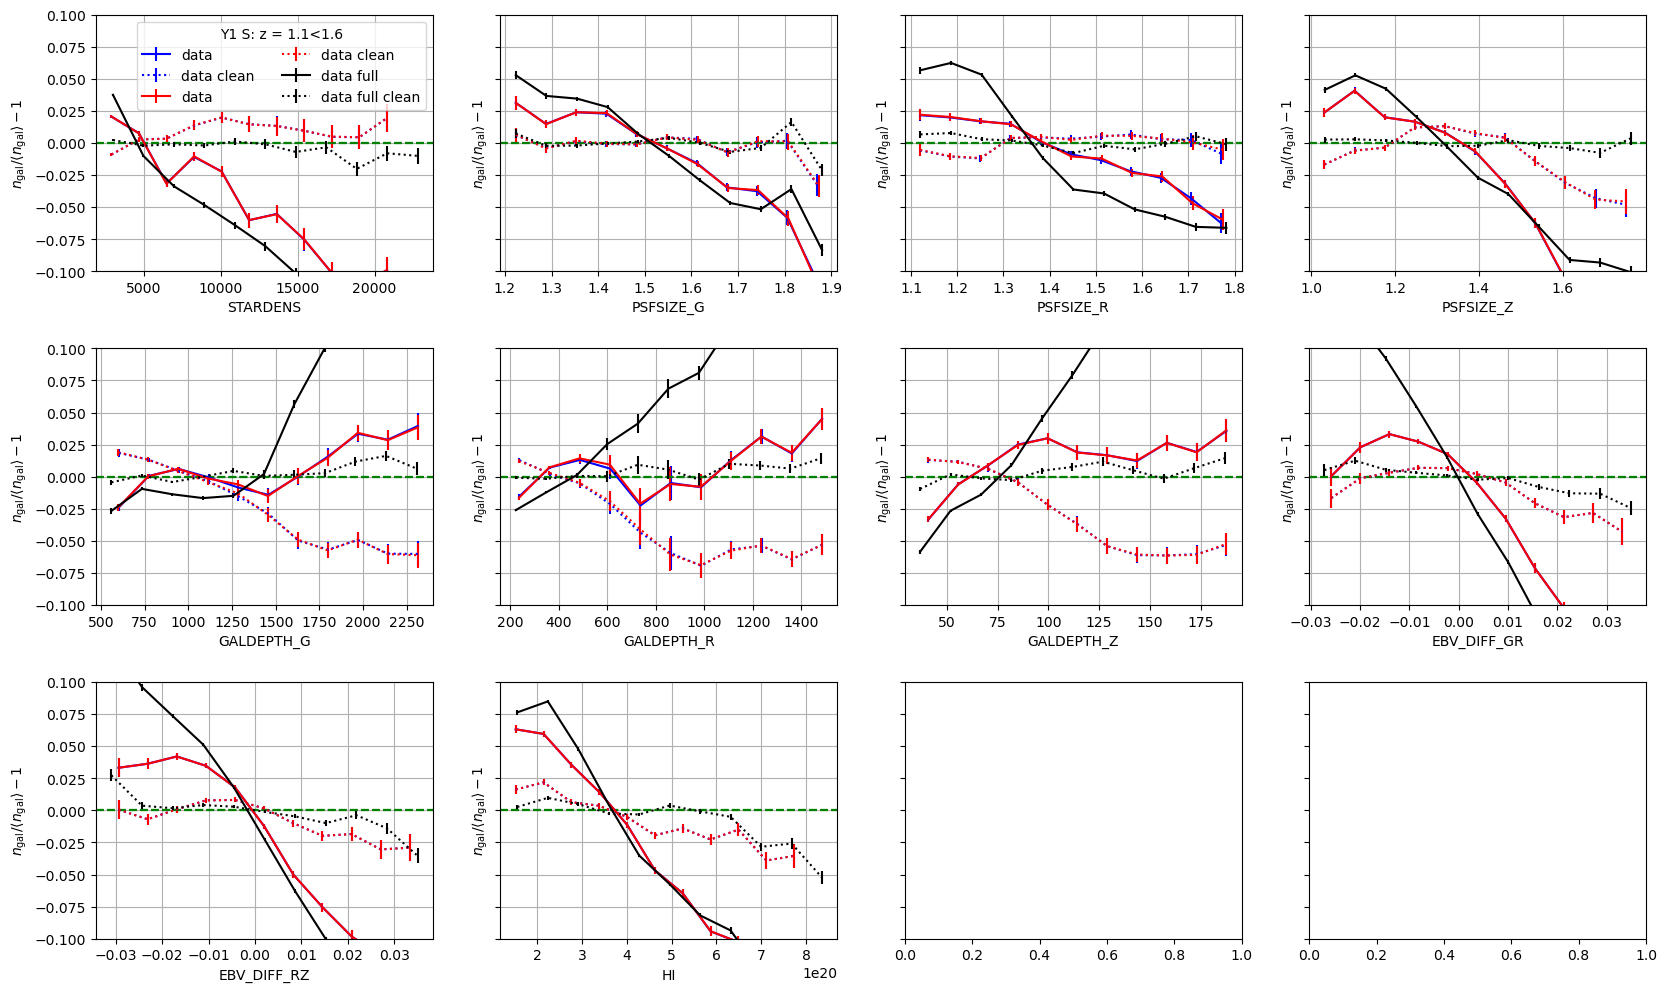

In [92]:
binning = 'linear'
ylim = (-0.3, +0.1)
#plot
fig,lax = plt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figsize=(20,12))
fig.subplots_adjust(hspace=0.3,wspace=0.2)
lax = lax.flatten()
add_maps = []
for iax, prop in enumerate(fit_maps+add_maps):
    kws = dict(binning=binning)
    # data
    hpmaps = sysnet_tools.create_sysmaps(sys_tabs[1], nest=nest, columns=fit_maps)
    ut.plot_density_variations(lax[iax], dats_m, drs_m, hpmaps, prop, mask_s, label=f'data', color='b', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], dats_mc, drs_m, hpmaps, prop, mask_s, label=f'data clean', color='b', linestyle=':', **kws) 
    
    hpmaps = sysnet_tools.create_sysmaps(sys_tabs[2], nest=nest, columns=fit_maps)
    ut.plot_density_variations(lax[iax], dats_m, drs_m, hpmaps, prop, mask_s, label=f'data', color='r', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], dats_mc, drs_m, hpmaps, prop, mask_s, label=f'data clean', color='r', linestyle=':', **kws)
    
    ut.plot_density_variations(lax[iax], dat_full_list[1], rands_full_list[1], hpmaps, prop, mask_full_list[1], label=f'data full', color='k', linestyle='-', **kws)
    ut.plot_density_variations(lax[iax], dat_fullc_list[1], rands_full_list[1], hpmaps, prop, mask_full_list[1], label=f'data full clean', color='k', linestyle=':', **kws)
    lax[iax].axhline(y=1.0, color='g')
lax[0].legend(title=f'Y1 S: z = {zmin}<{zmax}', ncol=2)
plt.savefig(f"density_{tp}_S_{zmin}_{zmax}.pdf")
plt.show()    
    

In [43]:
pwf = os.path.join("/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.4/",'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'.fits')
sys_tab = Table.read(pwf)

pwf = os.path.join("/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/",'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_N'+'.fits')
sys_tab_n = Table.read(pwf)

pwf = os.path.join("/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/",'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+'_S'+'.fits')
sys_tab_s = Table.read(pwf)
print(pwf)

/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/hpmaps/ELG_LOPnotqso_mapprops_healpix_nested_nside256_S.fits


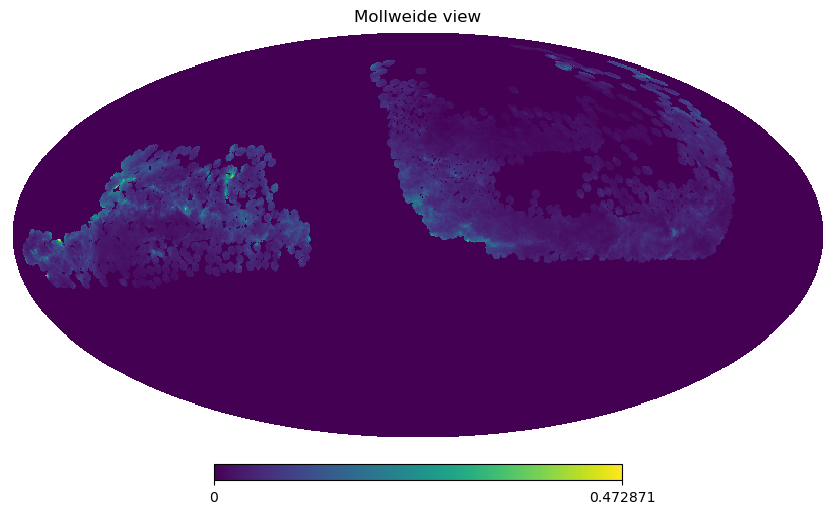

In [53]:
hp.mollview(sys_tab['EBV'], rot=260,nest=True)

In [39]:
count_i = np.zeros(12*nside*nside)
wind_i = np.zeros(12*nside*nside)
for reg in ['N','S']:
    print(reg)
    outfn =  os.path.join("/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/",'hpmaps',tp+'_mapprops_healpix_nested_nside'+str(nside)+f'_{reg}'+'.fits')
    m = fitsio.read(outfn)
    mask = m['EBV_CHIANG_SFDcorr'] > 0
    hpix = np.arange(12*nside*nside)[mask]
    count_i[hpix] += 1.0

N
S


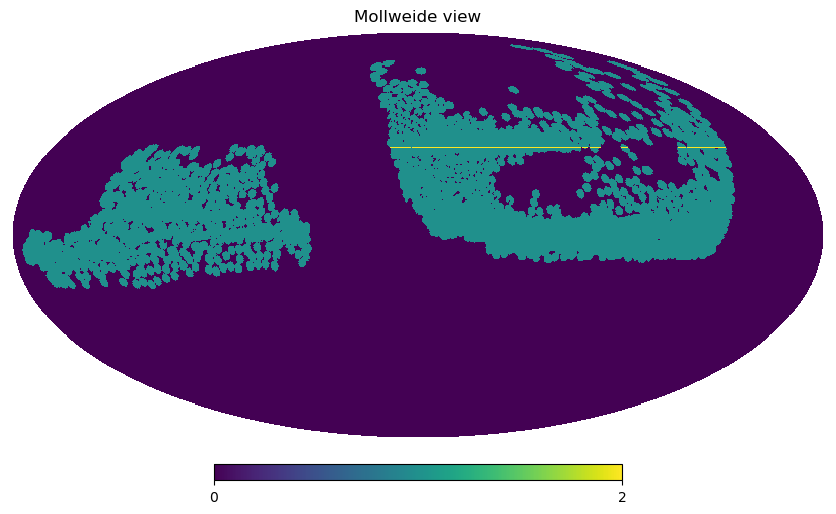

In [52]:
hp.mollview(count_i,rot=260,nest=True)

In [41]:
print(np.unique(count_i,return_counts=True))
is_good = count_i > 0.0

#wind_i[is_good] = wind_i[is_good] / count_i[is_good]
#wind_i[~is_good] = hp.UNSEEN

(array([0., 1., 2.]), array([596663, 189034,    735]))

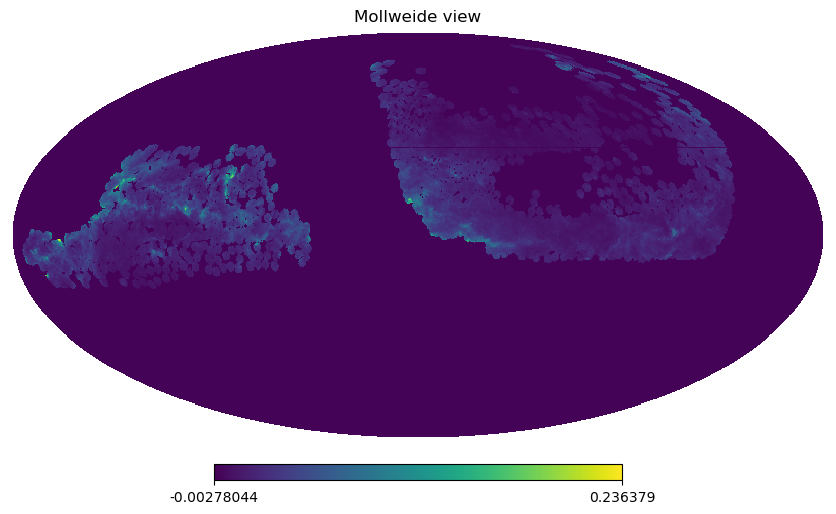

In [30]:
prop = 'EBV_CHIANG_SFDcorr'
diff = sys_tab[prop] - (sys_tab_s[prop]+sys_tab_n[prop])/2 
hp.mollview(diff,rot=260,nest=True)

In [33]:
sys_tab_s[prop][200],sys_tab_n[prop][200]

(0.095468186, 0.0)